In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
df_train = pd.read_csv('/home/lily/Downloads/stanford-cs229-master/me/data/quasar_train.csv')
df_test = pd.read_csv('/home/lily/Downloads/stanford-cs229-master/me/data/quasar_test.csv')

In [11]:
type(df_test.columns.values[0]) # 原来的数据类型是str
df_train.columns = df_train.columns.values.astype(float).astype(int) # 将数据类型修改为int

In [14]:
df_test.columns = df_test.columns.values.astype(float).astype(int)

In [15]:
assert (df_train.columns == df_test.columns).all()

In [16]:
print(df_train.shape)
print(df_test.shape)

(200, 450)
(50, 450)


### plot train and test data

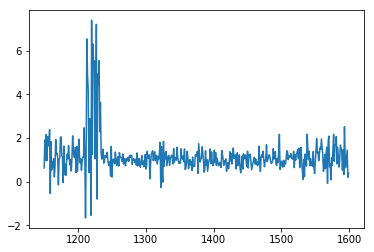

In [21]:
plt.plot(df_train.columns.values, df_train.iloc[0])

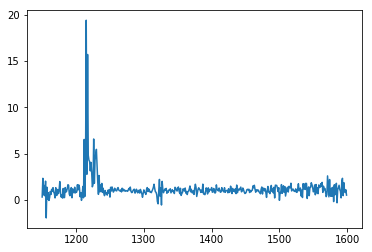

In [22]:
plt.plot(df_test.columns, df_test.iloc[20])

Implement $\theta = (X^T X)^{-1} X^T \vec{y}$ for normal cases, and $\theta = (X^T W X)^{-1} X^T W \vec{y}$ for general cases.

In [47]:
def optimal(X, y, W = None):
    if W is None:
        return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    else:
        return np.linalg.inv(X.T.dot(W).dot(X)).dot(X.T).dot(W).dot(y)

In [29]:
x0 = np.ones(df_train.shape[1])
x1 = df_train.columns.values
X = np.vstack([x0,x1]).T # y = k*x + b
y = df_train.iloc[0].values
# df_train.head(1).values.ravel()

In [39]:
theta = optimal(X, y)

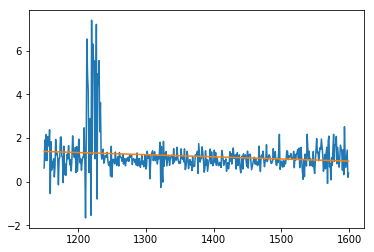

In [40]:
plt.plot(x1, y)
plt.plot(x1, X.dot(theta))

In [45]:
def weight_matrix(X, x_eval, tau = 5):
    w_diag = np.exp(-(X[:,1] - x_eval[1]) ** 2 / (2 * tau ** 2))
    return np.diag(w_diag)

In [79]:
res = []
preds = []
for i, x_eval in enumerate(X):
    W = weight_matrix(X, x_eval)
    theta = optimal(X, y, W)
    preds.append(x_eval.dot(theta.T)) # 等同于 preds.append(x_eval.dot(theta))== pred.append(theta.dot(x_eval))

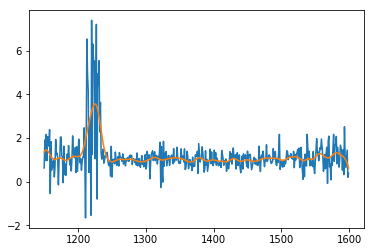

In [80]:
plt.plot(x1, y)
plt.plot(x1, preds)

locally weighted linear regression,对每一个新的reference的点都要重新拟合一次训练数据，所以是无参数模型，虽然拟合比线性回归好，但是计算开销比较大。

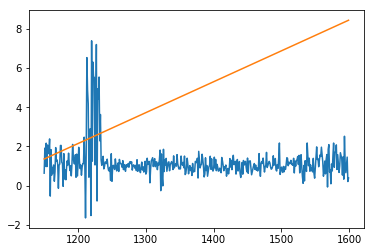

In [54]:
plt.plot(x1, y)
plt.plot(x1, preds[0])

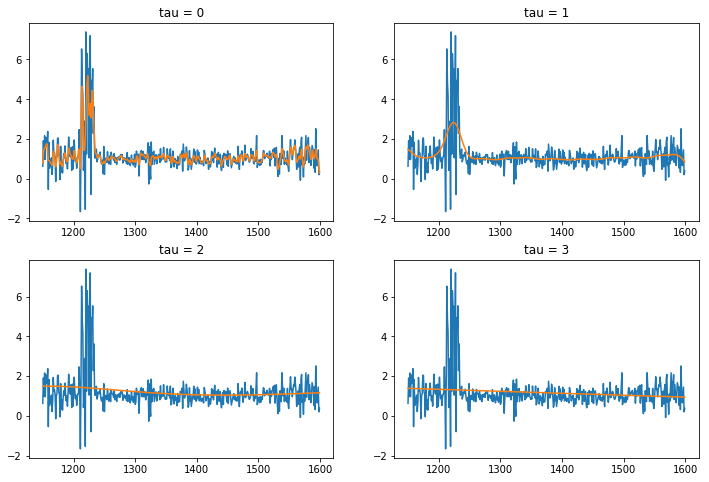

In [85]:
taus = [1, 10, 100, 1000]

fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.ravel() # 原本axes是（2,2）

for k, tau in enumerate(taus):
    ax = axes[k]
    predicts = []
    for i, x_eval in enumerate(X):
        W = weight_matrix(X, x_eval, tau)
        theta = optimal(X, y, W)
        predicts.append(x_eval.dot(theta))
    ax.plot(x1, y)
    ax.plot(x1, predicts)
    ax.set_title('tau = %d'%(k))

由上面的图形可以看出来，当tau很小的时候，预测曲线越不平坦（噪声越多），也就是受训练数据和reference的数据的距离的影响越大。当tau很大的时候，预测曲线很平坦。

### 以下部分是对quasar spectra做预测
(i) 为了让训练数据对prediction更加有效，我们首先需要通过locally weighted linear regression来平滑数据。  
在这里采用tau = 5平滑数据，对test set采用同样的参数。

In [88]:
def loer_single(X,y,x_eval,tau):
    """
    locally weighted regression for a single obeservationn
    """
    W = weight_matrix(X, x_eval, tau)
    theta = optimal(X, y, W)
    return theta

def loer(X, y, x_evals, tau):
    """
    locally weights regression for multiple x_evals
    """
    thetas = []
    for x_eval in x_evals:
        theta = loer_single(X, y, x_eval, tau)
        thetas.append(theta)
    return thetas

In [89]:
# 平滑训练数据
smoothed = []

x0 = np.ones(df_train.shape[1])
x1 = df_train.columns.values
X = np.vstack([x0,x1]).T # y = k*x + b
for k, row in df_train.iterrows():
    y = row.values
    thetas = loer(X, y, X, tau = 5)
    pred = [_t.dot(_x) for (_t, _x) in zip(thetas, X)]
    smoothed.append(pred)
df_smoothed_train = pd.DataFrame(smoothed, columns = df_train.columns)
    

In [92]:
# 平滑测试数据
smooth_test = []
for k, row in df_test.iterrows():
    y = row.values
    thetas = loer(X, y, X, tau = 5)
    pred = [_t.dot(_x) for (_t, _x) in zip(thetas, X)]
    smooth_test.append(pred)
df_smoothed_test = pd.DataFrame(smooth_test, columns = df_test.columns)

In [102]:
wave_len = df_train.columns.values
print(wave_len.min())
print(wave_len.max())

1150
1599


In [109]:
left_wave = wave_len[wave_len < 1200]
right_wave = wave_len[wave_len >= 1300]
print(left_wave.shape)
print(right_wave.shape)
df_smoothed_train_r = df_smoothed_train[right_wave]
df_smoothed_train_l = df_smoothed_train[left_wave]
print(df_smoothed_train_r.shape)
print(df_smoothed_train_l.shape)

(50,)
(300,)
(200, 300)
(200, 50)


### 这里根据题目要quid通过$f_{right}$对$f_{left}$进行拟合
参数设置： k = 3

In [112]:
def ker(t):
    return np.maximum(1-t, 0)

In [140]:
num_neighbors = 3
errors = []
preds_train = []
for k, row in df_smoothed_train_r.iterrows():
    dists = ((df_smoothed_train_r - row) ** 2).sum(axis = 1)
    #  print(dists) # dists是序号和dist pair
    max_d = dists.max()
    # print(max_d)
    neighbor_d = dists.sort_values()[:num_neighbors]
    # print(neighbor_d)
    
    # numerator = np.sum([ker(d/max_d)*df_smoothed_train_l.loc[idx] for (idx, d) in neighbor_d.iteritems()], axis = 0)
    numerator = (ker(neighbor_d/max_d).values.reshape(-1,1) * df_smoothed_train_l.loc[neighbor_d.index].values).sum(axis = 0)
    denominator = np.sum(ker(neighbor_d/max_d))
    f_left_hat = numerator / denominator
    preds_train.append(f_left_hat)
    error = np.sum((f_left_hat - df_smoothed_train_l.loc[k]) ** 2)
    errors.append(error)

In [142]:
print(np.mean(errors))

1.0663958023558322


### 可视化某些f_left_hat

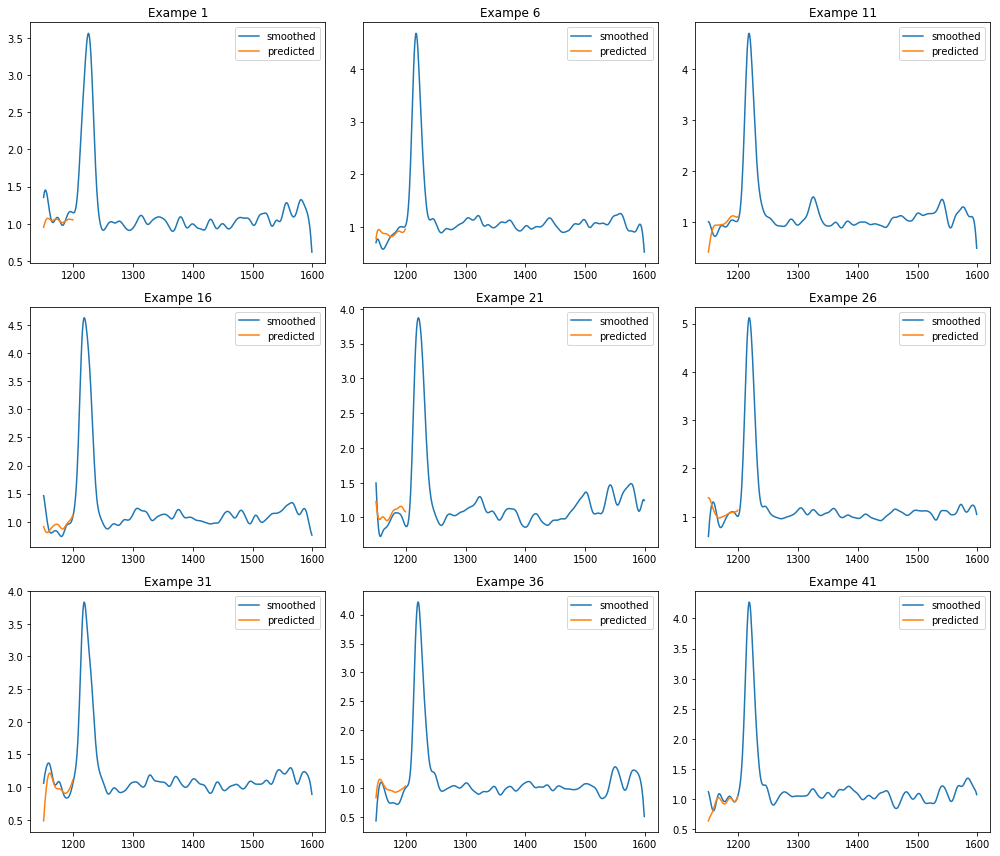

In [144]:
fig, axes = plt.subplots(3,3,figsize=(14,12))
axes = axes.ravel()

for k, idx in enumerate([0,5,10,15,20,25,30,35,40]):
    ax = axes[k]
    ax.plot(wave_len, df_smoothed_train.loc[idx], label = 'smoothed')
    ax.plot(left_wave, preds_train[idx], label='predicted')
    ax.legend()
    ax.set_title('Exampe %d'%(idx+1))
plt.tight_layout()

### 用训练数据预测测试数据

In [145]:
df_smoothed_test_r = df_smoothed_test[right_wave]
df_smoothed_test_l = df_smoothed_test[left_wave]

In [151]:
errs_test = []
preds_test = []
for k, row in df_smoothed_test_r.iterrows():
    dists = np.sum((df_smoothed_train_r - row) ** 2, axis = 1)
    max_d = dists.max()
    neighbor_d = dists.sort_values()[:num_neighbors]
    
    numerator = np.sum(ker(neighbor_d/max_d).values.reshape(-1,1) * df_smoothed_train_l.loc[neighbor_d.index].values, axis = 0)
    denominator = np.sum(ker(neighbor_d/max_d))
    f_left_hat = numerator / denominator
    preds_test.append(f_left_hat)
    error = np.sum((f_left_hat - df_smoothed_test_l.loc[k]) ** 2)
    errs_test.append(error)

In [152]:
print(np.mean(errs_test))

2.7099695793602576


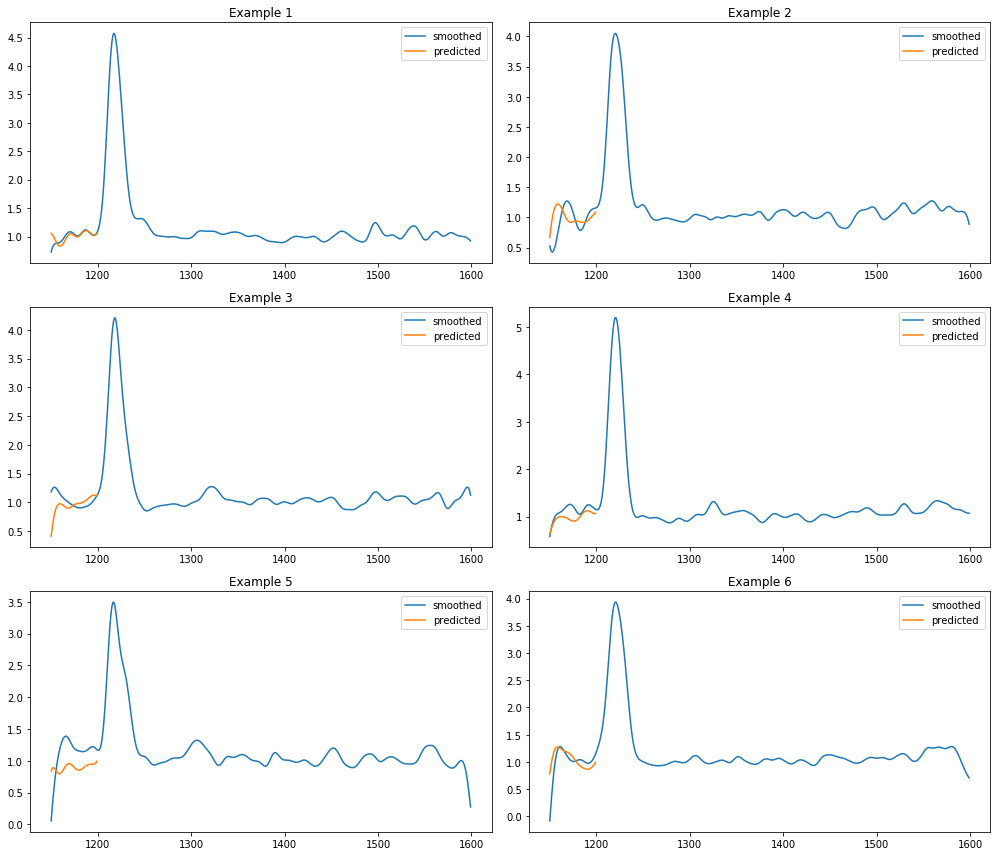

In [155]:
fig, axes = plt.subplots(3, 2, figsize = (14,12))
axes = axes.ravel()

for k, idx in enumerate([0,1,2,3,4,5]):
    ax = axes[k]
    ax.plot(wave_len, df_smoothed_test.loc[idx],label = 'smoothed')
    ax.plot(left_wave, preds_test[idx], label = "predicted")
    ax.legend()
    ax.set_title("Example %d"%(idx+1))
plt.tight_layout()   


如上图所示，这个预测效果不是很好，但是在题目中要求可视化的两张图片example1和exmaple6拟合的情况比较好。